# LASSOの問題点を検証
- 変数選択数の限界
- 説明変数間の相関があるときの問題

参考：https://stats.biopapyrus.jp/sparse-modeling/lasso.html

## 1. 変数選択数の限界
データのサンプル数が$n$, 変数の数が$p$で$p > n$の場合, 高々$n$個の変数までしか選択できない

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# データ数
n_samples = 100
# 真の変数の数
n_true_features = 150
# 全体の変数の数
n_features = 300

In [3]:
beta = np.zeros((n_features+1))
beta[:n_true_features] = np.random.randn(n_true_features)
X = np.ones((n_samples, n_features+1))
X[:, 1:] = np.random.randn(n_samples, n_features)
y = X @ beta + np.random.randn(n_samples)

In [4]:
print(X.shape)
print(beta.shape)
print(y.shape)

(100, 301)
(301,)
(100,)


In [5]:
class Lasso:
    def __init__(self, alpha=0.1, maxiter=100):
        self.alpha = alpha
        # number of ietration
        self.maxiter = maxiter
        
    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        L = 2*np.linalg.eig(X.T@X)[0].max() 
        z = self.w
        s = 1
        for i in range(self.maxiter):
            res = y - X @ z
            v = z + (X.T @ res) / L
            w_new = self._soft_threshold(v,  self.alpha / L)
            s_new  = (1 + np.sqrt(1 + 4 * s ** 2)) / 2
            z = self.w + (s - 1) / s_new * (w_new - self.w)
            
            self.w = w_new
            s = s_new
    
    def predict(self, X):
        return X @ self.w
        
    def _soft_threshold(self, y, alpha):
        return np.sign(y) * np.maximum(np.abs(y) - alpha, 0.0)

In [6]:
model = Lasso(maxiter=100000)
model.fit(X, y)

/Users/habakan/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


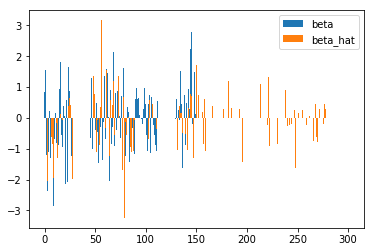

In [7]:
left = np.array([ i for i in range(len(beta)) ] )
plt.figure()
plt.bar(left, beta, label="beta")
plt.bar(left, model.w, label="beta_hat")
plt.legend()
plt.show()

### 非ゼロの係数の数
特徴選択された数

In [8]:
# 非ゼロの係数の数
np.sum(np.abs(model.w) != 0, axis=0)

125

## 説明変数間の相関がある
説明変数同士の相関が高い場合、その中から 1 つしか選択されない

### 検証
共分散が0ではない多次元正規分布から3次元のデータを作成

In [9]:
# データ数
n_samples = 10000
# 真の変数の数
n_true_features = 15
# 全体の変数の数
n_features = 30

In [10]:
sigma = np.eye(n_features, n_features)

In [11]:
mu = [0, 0, 0]
#sigma = [[0.5, 0.9, 0.9], [0.9, 0.5, 0.9], [0.9, 0.9, 0.5]]
sigma = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]

X = np.ones((n_samples, n_features+1))
for i in range(1, n_features+1, 3):
    values = np.random.multivariate_normal(mu, sigma, n_samples)
    X[:, i:i+3] = values

beta = np.zeros((n_features+1))
beta[0] = np.random.randn(1)
beta[:n_true_features] = np.random.randn(n_true_features)
'''
for i in range(1, n_true_features+1, 3):
    values = np.random.multivariate_normal(mu, sigma, 1).reshape(-1)
    beta[i:i+3] = values
'''
y = X @ beta + np.random.randn(n_samples) * 0.1

In [12]:
print(X.shape)
print(beta.shape)
print(y.shape)

(10000, 31)
(31,)
(10000,)


In [13]:
class GroupLasso:
    def __init__(self, group_ids, alpha=1e-3, eta=1e-1, maxiter=100):
        self.alpha = alpha
        self.eta = eta
        self.maxiter = maxiter
        # group id
        self.group_ids = group_ids
        
    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        L = 2*np.linalg.eig(X.T@X)[0].max() 
        z = self.w
        s = 1
        for i in range(self.maxiter):
            res = y - X @ z
            
            v = z + (X.T @ res) / L * self.eta
            #print(self.alpha * self.eta / L)
            w_new = self._proximal_operator(v,  self.alpha * self.eta )
            s_new  = (1 + np.sqrt(1 + 4 * s ** 2)) / 2
            z = self.w + (s - 1) / s_new * (w_new - self.w)
            
            self.w = w_new
            s = s_new
        
    def _proximal_operator(self, v, thresh):
        result_w = np.zeros_like(self.w).astype(np.float64)
        for group_id in self.group_ids:
            # 該当するgroupのみ係数を抽出
            group_coef_idx = self.group_ids == group_id
            group_coef = v[group_coef_idx]
            
            # L2ノルムの計算
            group_norm = np.linalg.norm(group_coef, 2)
            
            # soft_threshold関数
            if group_norm == 0:
                multiplier = 0
            else:
                #print(group_norm)
                multiplier = np.maximum(0, 1 -  thresh / group_norm)
            
            result_w[group_coef_idx] = multiplier * group_coef
            
        return result_w
    
    def predict(self, X):
        return X @ self.w

In [14]:
model = Lasso(alpha=0.1, maxiter=5000)
model.fit(X, y)

/Users/habakan/.pyenv/versions/3.6.0/lib/python3.6/site-packages/matplotlib/transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


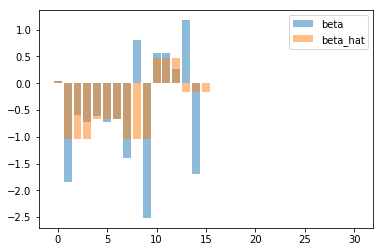

In [15]:
left = np.array([ i for i in range(len(beta)) ] )
plt.figure()
plt.bar(left, beta, label="beta", alpha=0.5)
plt.bar(left, model.w, label="beta_hat", alpha=0.5)
plt.legend()
plt.show()

In [16]:
X_test = np.ones((n_samples, n_features+1))
for i in range(1, n_features+1, 3):
    values = np.random.multivariate_normal(mu, sigma, n_samples)
    X_test[:, i:i+3] = values
y_test = X_test @ beta

In [17]:
print('MSE: ', np.linalg.norm(y_test - model.predict(X_test)))

MSE:  0.2111889063636558


In [18]:
alpha = 0.001
eta = 0.2
group_ids = np.zeros(n_features+1)
group_ids[1:] = np.array([[i, i, i] for i in range(1, int(n_features/3)+1)]).reshape(-1)
glasso = GroupLasso(group_ids=group_ids, alpha=alpha, eta=eta, maxiter=5000)
glasso.fit(X, y)

/Users/habakan/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


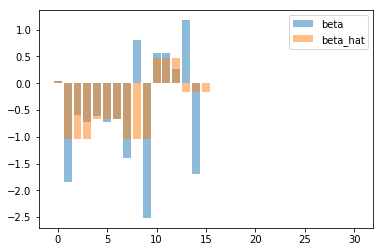

In [19]:
left = np.array([ i for i in range(len(beta)) ] )
plt.figure()
plt.bar(left, beta, label="beta", alpha=0.5)
plt.bar(left, glasso.w, label="beta_hat", alpha=0.5)
plt.legend()
plt.show()

In [20]:
print('MSE: ', np.linalg.norm(y_test - glasso.predict(X_test)))

MSE:  1.0379903909118453


In [21]:
import matplotlib.pyplot as plt

In [22]:
def draw_heatmap(data):
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    plt.show()

    return heatmap

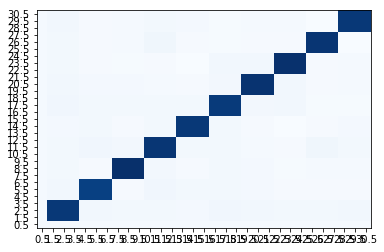

In [23]:
draw_heatmap(np.cov(X.T))